In [1]:
import warnings
warnings.filterwarnings('ignore')
import shutil
import tensorflow as tf
import sys
sys.path.append('lib/')
from heatmaps_utils import *
from keras.applications.inception_v3 import preprocess_input
import setproctitle
import model_utils

Using TensorFlow backend.


ImportError: cannot import name tf_utils

In [2]:
## GPU config
gpus = [0]
configtf = tf.ConfigProto(allow_soft_placement=True)
configtf.gpu_options.allow_growth = True
#configtf.gpu_options.visible_device_list = ','.join(str(gpu) for gpu in gpus)
init = tf.global_variables_initializer()
sess = tf.Session(config=configtf)
sess.run(init)

In [3]:
EXPERIMENT_TYPE='cascading_random_ssim'
# SET PROCESS TITLE
setproctitle.setproctitle(EXPERIMENT_TYPE)

In [4]:
#LOAD MODEL
global model
from model_utils import *
model=get_baseline_model()

In [5]:
model2=get_random_baseline_model()

In [6]:
# dowload weights at: https://doi.org/10.5281/zenodo.4312783
model.load_weights('/pannuke_baseline_IV3_100epochs/best_model.h5')

In [7]:
last_conv='mixed10'

In [8]:
import os
res_folder = 'results/'
new_folder = res_folder + EXPERIMENT_TYPE
if not os.path.exists(new_folder):
    os.makedirs(new_folder)
#shutil.copy2(src=CONFIG_FILE, dst=os.path.join(new_folder, '.'))
import h5py as hd
# DATA PATHS
# download data at 
cam16 = hd.File('cam16_500/patches.hdf5', 'r')
all500 = hd.File('all500/patches.hdf5', 'r')
extra17 = hd.File('extra17/patches.hdf5', 'r')
tumor_extra17=hd.File('1129-1155/patches.hdf5','r')
test2 = hd.File('test_data2/patches.hdf5','r')
pannuke= hd.File('pannuke/patches.hdf5', 'r',)
#
global data
data={'cam16':cam16,'all500':all500,'extra17':extra17, 'tumor_extra17':tumor_extra17, 'test_data2': test2, 'pannuke':pannuke}

# DATA SPLIT CSVs
train_csv=open('Camelyon/train_shuffle.csv', 'r')
val_csv=open('Camelyon/val_shuffle.csv', 'r')
test_csv=open('Camelyon/test_shuffle.csv', 'r')
train_list=train_csv.readlines()
val_list=val_csv.readlines()
test_list=test_csv.readlines()
test2_csv = open('Camelyon/test2_shuffle.csv', 'r')
test2_list=test2_csv.readlines()
test2_csv.close()
train_csv.close()
val_csv.close()
test_csv.close()

data_csv=open('Camelyon/pannuke/pannuke_train_shuffled.csv', 'r')
data_list=data_csv.readlines()
data_csv.close()

# load PROCESS functionalities
sys.path.append('/home/mara/multitask_adversarial/lib/TASK_2_UC1/')
from normalizers import ReinhardNormalizer

# STAIN NORMALIZATION
def get_normalizer(patch, save_folder=''):
    normalizer = ReinhardNormalizer()
    normalizer.fit(patch)
    np.save('{}/normalizer'.format(save_folder),normalizer)
    np.save('{}/normalizing_patch'.format(save_folder), patch)
    print('Normalisers saved to disk.')
    return normalizer

def normalize_patch(patch, normalizer):
    return np.float64(normalizer.transform(np.uint8(patch)))

def get_keys(l):
    db_name=l.split(', ')[0]
    entry_path=l.split(', ')[1]
    patch_no=l.split(', ')[2]
    return db_name, entry_path, int(patch_no)

def get_class_name(entry_path):
    if 'normal' in entry_path:
        return 'normal'
    else: 
        return 'tumor'
#    return entry_path.split('/')[0]

def load_patch_mask(patch_address, patch_idx, source_fld=''):
    mask=np.zeros((224,224,4))
    patch_path=source_fld+'/{}'.format(patch_idx) 
    #import pdb; pdb.set_trace()
    try:
        for nuclei_mask in os.listdir(patch_path):
            mask += plt.imread(patch_path+'/'+nuclei_mask)
        n_nuclei=len(os.listdir(patch_path))
        return mask, n_nuclei
    except:
        patch_path=source_fld+patch_address.split('/node')[0]+'/{}'.format(patch_idx)
        #print patch_path
        for nuclei_mask in os.listdir(patch_path):
            mask += plt.imread(patch_path+'/'+nuclei_mask)
        n_nuclei=len(os.listdir(patch_path))
        return mask, n_nuclei

# LOAD DATA NORMALIZER
global normalizer
db_name, entry_path, patch_no = get_keys(data_list[0])
normalization_reference_patch = data[db_name][entry_path][patch_no]
normalizer = get_normalizer(normalization_reference_patch, save_folder=new_folder)
def get_cam_model_resnet101(model, last_conv_layer, pred_layer):
    n_classes = model.output_shape[-1]
    final_params = model.get_layer(pred_layer).get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, n_classes), final_params[1])

    last_conv_output = model.get_layer(last_conv_layer).output
    # upgrade keras to 2.2.3 in order to use UpSampling2D with bilinear interpolation
    # x = UpSampling2D(size=(32, 32))(last_conv_output)
    x = Conv2D(filters=n_classes, kernel_size=(1, 1), name='predictions_2')(last_conv_output)

    cam_model = Model(inputs=model.input, outputs=[model.output, x])
    cam_model.get_layer('predictions_2').set_weights(final_params)
    return cam_model

def postprocess(preds, cams, top_k=1):
    idxes = np.argsort(preds[0])[-top_k:]
    class_activation_map = np.zeros_like(cams[0, :, :, 0])
    for i in idxes:
        class_activation_map += cams[0, :, :, i]
    return class_activation_map

def get_cam_model_iv3(model, last_conv_layer, pred_layer):
    n_classes = model.output_shape[-1]
    final_params = model.get_layer(pred_layer).get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, n_classes), final_params[1])

    last_conv_output = model.get_layer(last_conv).output
    # upgrade keras to 2.2.3 in order to use UpSampling2D with bilinear interpolation
    # x = UpSampling2D(size=(32, 32))(last_conv_output)
    x = Conv2D(filters=2048, kernel_size=(1, 1), name='extra_layer1_2')(last_conv_output)
    x = Conv2D(filters=512, kernel_size=(1,1), name='extra_layer2_2')(x)
    x = Conv2D(filters=256, kernel_size=(1,1), name='extra_layer3_2')(x)
    x = Conv2D(filters=n_classes, kernel_size=(1,1), name='predictions_2')(x)
    cam_model = Model(inputs=model.input, outputs=[model.output, x])

    final_params = model.get_layer('finetuned_features1').get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, 2048), final_params[1])
    
    cam_model.get_layer('extra_layer1_2').set_weights(final_params)
    final_params = model.get_layer('finetuned_features2').get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, 512), final_params[1])
    cam_model.get_layer('extra_layer2_2').set_weights(final_params)
    final_params = model.get_layer('finetuned_features3').get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, 256), final_params[1])
    cam_model.get_layer('extra_layer3_2').set_weights(final_params)
    final_params = model.get_layer(pred_layer).get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, n_classes), final_params[1])
    cam_model.get_layer('predictions_2').set_weights(final_params)
    
    return cam_model
def cam(model, img, last_conv, original_size, pred_layer=None):
    if pred_layer is None:
        pred_layer = model.layers[-1].name
    cam_model = get_cam_model_iv3(model, last_conv_layer=last_conv, pred_layer=pred_layer)
    preds, cams = cam_model.predict(img)
    class_activation_map = postprocess(preds, cams)
    return cv2.resize(class_activation_map, original_size)
### gradCAM ###
def gradcam(model, img, layer_name, original_size):
    """ Grad-CAM function """
    
    cls = np.argmax(model.predict(img))
    
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Get outputs and grads
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    
    weights = np.mean(grads_val, axis=(0, 1)) # Passing through GlobalAveragePooling

    cam = np.dot(output, weights) # multiply
    cam = np.maximum(cam, 0)      # Passing through ReLU
    #cam /= np.max(cam)            # scale 0 to 1.0

    cam = cv2.resize(cam, original_size)
    return cam
### gradCAM++ ###
def gradcam_plus_plus(model, img, layer_name, original_size):
    """ Grad-CAM++ function """
    
    cls = np.argmax(model.predict(img))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads

    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom # 0


    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0) # 0
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[2])) # NAN
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[2])), axis=0)

    cam = np.sum(deep_linearization_weights * conv_output[0], axis=2)
    cam = np.maximum(cam, 0) # Passing through ReLU
    #cam /= np.max(cam)       # scale 0 to 1.0  

    cam = cv2.resize(cam, original_size)
    return cam
# get data from 
test_cvs_ =open('/Camelyon/pannuke/test_pannuke_shuffled.csv', 'r')
test_pannuke_list=test_cvs_.readlines()
pannuke_data=[]
for d in test_pannuke_list:
    if 'pannuke' in d:
        pannuke_data.append(d)
# get data from 
pannuke= hd.File('Camelyon/pannuke_test/patches.hdf5', 'r',)
data={'cam16':cam16,'all500':all500,'extra17':extra17, 'tumor_extra17':tumor_extra17, 'test_data2': test2, 'pannuke':pannuke}

Using brightness standardization
Normalisers saved to disk.


In [9]:
def binarize_mask(mask):
    return (mask>0)*1
def get_semantic_mask(masks):
    binary_mask={}
    for mask_type in range(6):
        binary_mask[mask_type]=binarize_mask(masks[:,:,mask_type])
    semantic_mask=np.zeros((224,224))    
    for mask_type in range(0,5):
        semantic_mask += (mask_type+1) * binary_mask[mask_type]
    #semantic_mask-=binary_mask[5]
    return semantic_mask
def binarize_all_masks(masks):
    binary_masks={}
    for i in range(6):
        binary_masks[i]=binarize_mask(masks[:,:,i])
    return binary_masks

In [10]:
test_cvs_ =open('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/test_pannuke_shuffled.csv', 'r')
test_pannuke_list=test_cvs_.readlines()
pannuke_data=[]
for d in test_pannuke_list:
    if 'pannuke' in d:
        pannuke_data.append(d)
train_list=pannuke_data

In [11]:
model.load_weights('pannuke_baseline_IV3_100epochs/best_model.h5')

In [13]:
model3=get_baseline_model()
model3.load_weights('pannuke_baseline_IV3_100epochs/best_model.h5')

In [14]:
#train_list= [#'pannuke, pannuke/fold3/509/normal/center/patch, 0, train',
             #'pannuke, pannuke/fold3/309/normal/center/patch, 0, train',
#             'pannuke, pannuke/fold3/331/tumor/upper_left/patch, 0, train',
             #'pannuke, pannuke/fold3/237/tumor/upper_right/patch, 0, train'
#            ]
# Segmentation methods used to compute superpixels needed for LIME
seg_methods = {#'Quickshift':segments_quick,
               'SLIC':segments_slic,
               'Felzenszwalb':segments_fz,
              }

# Boxes size should be a divisor of input size
# Too high sizes will give too small boxes and low weights
# for computing Squaregrid (so no impact)
# They used 3/4/6/8/12/16/24 in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6651753/
boxes_size = []#4, 7, 8, 14, 16, 28] #, 32, 56, 112, 224]
for k in boxes_size:
    assert input_size[0] % k == 0

for k in (boxes_size):
    seg_methods['boxes_{}'.format(k*k)] = k
    
# pertubed_images = []
# pertubed_images_preds = []

def predict(patches, normalizer=normalizer, model=model):
    inputs = []
    for patch in patches:
        inputs.append(normalize_patch(patch, normalizer))
    inputs = np.asarray(inputs, dtype=np.float32)
    inputs = preprocess_input(inputs)
#     pertubed_images.extend(patches)
#     pertubed_images_preds.extend(preds)
    return model.predict(inputs)  
def predict_true(patches, normalizer=normalizer, model=model3):
    inputs = []
    for patch in patches:
        inputs.append(normalize_patch(patch, normalizer))
    inputs = np.asarray(inputs, dtype=np.float32)
    inputs = preprocess_input(inputs)
#     pertubed_images.extend(patches)
#     pertubed_images_preds.extend(preds)
    return model.predict(inputs) 

In [15]:
t_list=[]
for e in train_list:
    if 'tumor' in e:
        t_list.append(e)

In [16]:
t_list

['pannuke, pannuke/fold3/523/tumor/upper_right/patch, 0, train\n',
 'pannuke, pannuke/fold3/856/tumor/upper_left/patch, 0, train\n',
 'pannuke, pannuke/fold3/373/tumor/lower_right/patch, 0, train\n',
 'pannuke, pannuke/fold3/439/tumor/lower_right/patch, 0, train\n',
 'pannuke, pannuke/fold3/29/tumor/lower_left/patch, 0, train\n',
 'pannuke, pannuke/fold3/377/tumor/lower_left/patch, 0, train\n',
 'pannuke, pannuke/fold3/1663/tumor/upper_left/patch, 0, train\n',
 'pannuke, pannuke/fold3/329/tumor/center/patch, 0, train\n',
 'pannuke, pannuke/fold3/607/tumor/center/patch, 0, train\n',
 'pannuke, pannuke/fold3/599/tumor/center/patch, 0, train\n',
 'pannuke, pannuke/fold3/544/tumor/lower_right/patch, 0, train\n',
 'pannuke, pannuke/fold3/353/tumor/lower_right/patch, 0, train\n',
 'pannuke, pannuke/fold3/269/tumor/lower_right/patch, 0, train\n',
 'pannuke, pannuke/fold3/319/tumor/upper_left/patch, 0, train\n',
 'pannuke, pannuke/fold3/667/tumor/lower_left/patch, 0, train\n',
 'pannuke, pannu

In [ ]:
# Cascading randomization 
layers=model.layers_by_depth
last_conv='mixed10'
input_size=(224,224)
#degradated_hm={}
depth_limit=len(layers.keys())
#counter=318
avg_ssims_={}
explainer = lime_image.LimeImageExplainer()
for l in layers.keys()[:depth_limit]:
    layers_at_depth=layers[l]
    layers_at_depth2=model2.layers_by_depth[l]
    #print layers_at_depth
    counter=0
    for layer in layers_at_depth:
        print layer.name, layers_at_depth2[counter].name
        #weights=model.get_layer(layer.name).get_weights()
        r_weights=layers_at_depth2[counter].get_weights()
        print 'Reset weights of {}'.format(layer.name)
        counter+=1
        layer.set_weights(r_weights)
        if layer.name in ['predictions','mixed10','mixed9','mixed8','mixed7', 'mixed6',  'mixed5', 'mixed4', 'mixed3', 'mixed2','mixed1', 'mixed0']:
            print layer.name
            ssim_={'CAM':[], 'gradCAM':[], 'gradCAM++': [], 'SLIC': [], 'Felzenszwalb': []}
            for element in t_list[:100]:
                true_hm={}
                db_name, entry_path, patch_no = get_keys(element)
                _type = get_class_name(entry_path)
                path = element.split(',')[1].strip(' ')[:-5]
                masks = data['pannuke'][path+'mask'][0]
                image= data['pannuke'][path+'patch'][0]
                binary_masks=binarize_all_masks(masks)
                inputs = normalize_patch(image, normalizer)
                inputs = np.expand_dims(inputs, axis=0)
                inputs = preprocess_input(inputs)
                preds = tf.sigmoid(model.predict(inputs)[0]).eval(session=tf.Session())

                _heatmaps = {}
                #_heatmaps['path'] = element
                #_heatmaps['type'] = _type
                #_heatmaps['pred'] = preds
                #_heatmaps['original'] = data['pannuke'][path+'patch'][0]
                #_heatmaps['mask'] = binary_masks

                ### CAM ###
                _heatmaps['CAM'] = cam(model, inputs, last_conv, input_size)
                true_hm['CAM']=cam(model3, inputs, last_conv, input_size)
                ### gradCAM ###
                _heatmaps['gradCAM'] = gradcam(model, inputs, last_conv, input_size)
                true_hm['gradCAM']=gradcam(model3, inputs, last_conv, input_size)
                ### gradCAM++ ###
                _heatmaps['gradCAM++'] = gradcam_plus_plus(model, inputs, last_conv, input_size)
                true_hm['gradCAM++']=gradcam_plus_plus(model3, inputs, last_conv, input_size)
                #heatmaps=compute_cams(_heatmaps) 
                ### LIME ###
                for name, segmentation_fn in seg_methods.items():
                    #if name.startswith('boxes_'):
                    #    k = segmentation_fn
                    #    segmentation_fn = lambda i : segments_box(i, k, input_size)
                    true_hm[name]=[]
                    _heatmaps[name]=[]
                    #try:
                    explanation = explainer.explain_instance(image, predict, top_labels=1, hide_color=0,
                                                         num_samples=1000, segmentation_fn=segmentation_fn, num_features=100)
                    explanation_true = explainer.explain_instance(image, predict_true, top_labels=1, hide_color=0,
                                                         num_samples=1000, segmentation_fn=segmentation_fn, num_features=100)
                    # Select the same class explained on the figures above.
                    ind =  explanation.top_labels[0]
                    ind_true = explanation_true.top_labels[0]
                    # Map each explanation weight to the corresponding superpixel
                    dict_heatmap = dict(explanation.local_exp[ind])
                    dict_heatmap_true = dict(explanation_true.local_exp[ind])

                    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
                    heatmap = np.nan_to_num(np.asarray(heatmap, dtype=float))

                    true_hm[name] = np.vectorize(dict_heatmap_true.get)(explanation_true.segments)
                    true_hm[name] = np.nan_to_num(np.asarray(true_hm[name], dtype=float))

                    _heatmaps[name] = heatmap
                    #except:
                    #    print 'not working'
                    #    _heatmaps[name]=np.ones((input_size))
                for meth in ['CAM', 'gradCAM', 'gradCAM++', 'SLIC', 'Felzenszwalb']:
                    ssim_[meth].append(ssim(true_hm[meth], _heatmaps[meth]))
            avg_ssims_[layer.name]={}
            for meth in ['CAM', 'gradCAM', 'gradCAM++', 'SLIC', 'Felzenszwalb']:
                avg_ssims_[layer.name][meth]=np.mean(ssim_[meth])
            print layer.name
            #degradated_hm[layer.name]=_heatmaps

predictions predictions
Reset weights of predictions
predictions


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

predictions
finetuned_features3 finetuned_features3
Reset weights of finetuned_features3
dropout_3 dropout_6
Reset weights of dropout_3
finetuned_features2 finetuned_features2
Reset weights of finetuned_features2
dropout_2 dropout_5
Reset weights of dropout_2
finetuned_features1 finetuned_features1
Reset weights of finetuned_features1
dropout_1 dropout_4
Reset weights of dropout_1
avg_pool avg_pool
Reset weights of avg_pool
mixed10 mixed10
Reset weights of mixed10
mixed10


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

mixed10
activation_86 activation_180
Reset weights of activation_86
mixed9_1 mixed9_1
Reset weights of mixed9_1
concatenate_2 concatenate_4
Reset weights of concatenate_2
activation_94 activation_188
Reset weights of activation_94
batch_normalization_86 batch_normalization_180
Reset weights of batch_normalization_86
activation_88 activation_182
Reset weights of activation_88
activation_89 activation_183
Reset weights of activation_89
activation_92 activation_186
Reset weights of activation_92
activation_93 activation_187
Reset weights of activation_93
batch_normalization_94 batch_normalization_188
Reset weights of batch_normalization_94
conv2d_86 conv2d_180
Reset weights of conv2d_86
batch_normalization_88 batch_normalization_182
Reset weights of batch_normalization_88
batch_normalization_89 batch_normalization_183
Reset weights of batch_normalization_89
batch_normalization_92 batch_normalization_186
Reset weights of batch_normalization_92
batch_normalization_93 batch_normalization_187

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

In [20]:
true_hm[name]

KeyError: 'Felzenszwalb'

In [21]:
ssim(true_hm[meth], _heatmaps[meth])

KeyError: 'Felzenszwalb'

In [47]:
true_hm[name] = np.nan_to_num(np.asarray(true_hm[name], dtype=float))

In [46]:
true_hm[name] = np.vectorize(dict_heatmap_true.get)(explanation_true.segments)

In [52]:
l

19

In [22]:
avg_ssims_

{'mixed10': {'CAM': 0.3787480501238399,
  'Felzenszwalb': 0.5837495139276665,
  'SLIC': 0.3610887621265533,
  'gradCAM': 0.40176295499086523,
  'gradCAM++': 0.4532618099135566},
 'predictions': {'CAM': -0.10586033312643554,
  'Felzenszwalb': 0.6281957298546814,
  'SLIC': 0.41175564466773457,
  'gradCAM': 0.10130937068199657,
  'gradCAM++': 0.018496551301265932}}

In [50]:
layer.name

'mixed9'

In [51]:
layers_at_depth

In [91]:
c=0
for m in model.layers_by_depth.keys():
    for l in model.layers_by_depth[m]:
        c+=1

In [90]:
for i in range(0, len(model.layers_by_depth)):  
    for l in model.layers_by_depth[i]:
        if 'mixed' in l.name:
            print l.name

mixed10
mixed9_1
mixed9
mixed9_0
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0


In [44]:
np.save('degradated_hm_def', degradated_hm)

In [14]:
degradated_hm=np.load('degradated_hm_def.npy').item()

IOError: [Errno 2] No such file or directory: 'degradated_hm_def.npy'

In [28]:
def predict(train_list=train_list, data=data, model=model):
    predictions=[]
    for element in train_list[:100]:
        db_name, entry_path, patch_no = get_keys(element)
        _type = get_class_name(entry_path)
        image = data[db_name][entry_path][patch_no]
        inputs = normalize_patch(image, normalizer)
        inputs = np.expand_dims(inputs, axis=0)
        inputs = preprocess_input(inputs)
        preds = tf.sigmoid(model.predict(inputs)[0]).eval(session=tf.Session())
        predictions.append(preds)
    return predictions

def predict_true(train_list=train_list, data=data, model=model3):
    predictions=[]
    for element in train_list[:100]:
        db_name, entry_path, patch_no = get_keys(element)
        _type = get_class_name(entry_path)
        image = data[db_name][entry_path][patch_no]
        inputs = normalize_patch(image, normalizer)
        inputs = np.expand_dims(inputs, axis=0)
        inputs = preprocess_input(inputs)
        preds = tf.sigmoid(model.predict(inputs)[0]).eval(session=tf.Session())
        predictions.append(preds)
    return predictions

def auc(predictions, gts=None):
    import sklearn.metrics
    auc=sklearn.metrics.roc_auc_score(gts,predictions)
    fpr, tpr, ths =sklearn.metrics.roc_curve(gts, predictions)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# AUC
predictions=predict()
auc(predictions)

In [20]:
element

'pannuke, pannuke/fold3/331/tumor/upper_left/patch, 0, train'

pannuke, pannuke/fold3/331/tumor/upper_left/patch, 0, train


(-0.5, 223.5, 223.5, -0.5)

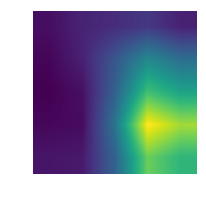

In [38]:
print degradated_hm[0]['path']
plt.rcParams['figure.figsize']=(3,3)
plt.imshow(np.asarray(degradated_hm[0]['gradCAM']))
plt.axis('off')

In [29]:
len(degradated_hm)

165

In [46]:
ls=['predictions',
    'mixed10',
 #'mixed9_1',
 #'mixed9_0',
 'mixed9',
 'mixed8',
'mixed7',
 'mixed6',
  'mixed5',
 'mixed4',
 'mixed3',
 'mixed2',
'mixed1',
 'mixed0']

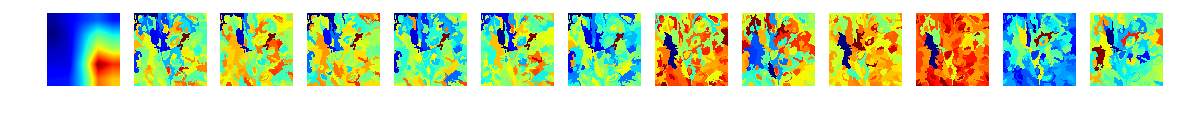

In [84]:

plt.rcParams['figure.figsize']=(20,20)
#plt.subplot(1, 41)
pos=2
plt.subplot(1, len(ls)+1, 1)
plt.imshow(true_hm[164]['CAM'], cmap='jet')
plt.axis('off')
for i in ls:
    plt.subplot(1, len(ls)+1, pos)
    plt.imshow(degradated_hm[i]['SLIC'], cmap='jet')
    plt.axis('off')
    pos+=1

In [35]:
hm=np.load('results/unbiased_iou_pannuke/FINAL_ALL_HM_LIST.npy')

In [21]:
# you need to compute it wihtout any. reinitialized layers
model.load_weights('pannuke_baseline_IV3_100epochs/best_model.h5')

In [22]:
# Cascading randomization 
layers=model.layers_by_depth
depth_limit=1
last_conv='mixed10'
input_size=(224,224)
true_hm={}
for element in train_list:
    db_name, entry_path, patch_no = get_keys(element)
    _type = get_class_name(entry_path)
    path = element.split(',')[1].strip(' ')[:-5]
    masks = data['pannuke'][path+'mask'][0]
    image= data['pannuke'][path+'patch'][0]
    binary_masks=binarize_all_masks(masks)
    inputs = normalize_patch(image, normalizer)
    inputs = np.expand_dims(inputs, axis=0)
    inputs = preprocess_input(inputs)
    preds = tf.sigmoid(model.predict(inputs)[0]).eval(session=tf.Session())

    _heatmaps = {}
    _heatmaps['path'] = element
    _heatmaps['type'] = _type
    _heatmaps['pred'] = preds
    _heatmaps['original'] = data['pannuke'][path+'patch'][0]
    _heatmaps['mask'] = binary_masks

    ### CAM ###
    
    _heatmaps['CAM'] = cam(model, inputs, last_conv, input_size)
    ### gradCAM ###
    _heatmaps['gradCAM'] = gradcam(model, inputs, last_conv, input_size)
    ### gradCAM++ ###
    _heatmaps['gradCAM++'] = gradcam_plus_plus(model, inputs, last_conv, input_size)
    heatmaps=compute_cams(_heatmaps) 
    ### LIME ###
    for name, segmentation_fn in seg_methods.items():
        #if name.startswith('boxes_'):
        #    k = segmentation_fn
        #    segmentation_fn = lambda i : segments_box(i, k, input_size)
        try:
            explainer = lime_image.LimeImageExplainer()
            explanation = explainer.explain_instance(image, predict, top_labels=1, hide_color=0,
                                                 num_samples=1000, segmentation_fn=segmentation_fn, num_features=100)
            explanation_true = explainer.explain_instance(image, predict2, top_labels=1, hide_color=0,
                                                 num_samples=1000, segmentation_fn=segmentation_fn, num_features=100)

            # Select the same class explained on the figures above.
            ind =  explanation.top_labels[0]

            # Map each explanation weight to the corresponding superpixel
            dict_heatmap = dict(explanation.local_exp[ind])
            heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
            heatmap = np.nan_to_num(np.asarray(heatmap, dtype=float))
            _heatmaps[name] = heatmap
        except:
            _heatmaps[name]=np.ones((input_size))
    true_hm[l]=_heatmaps

100% |########################################################################|
100% |########################################################################|


In [28]:
true_hm.keys()

[164]

In [51]:
ssim_list={'CAM':[], 'gradCAM':[], 'gradCAM++':[], 'SLIC':[], 'Felzenszwalb':[]}
for meth in ['CAM', 'gradCAM', 'gradCAM++', 'SLIC',  'Felzenszwalb']:
    ssim_list[meth].append(ssim(true_hm[164][meth], true_hm[164][meth]))
for l in ls:
    print l
    for meth in ['CAM', 'gradCAM', 'gradCAM++', 'SLIC',  'Felzenszwalb']:
        ssim_list[meth].append(ssim(true_hm[164][meth], degradated_hm[l][meth]))

predictions
mixed10
mixed9
mixed8
mixed7
mixed6
mixed5
mixed4
mixed3
mixed2
mixed1
mixed0


Text(0,0.5,u'SSIM')

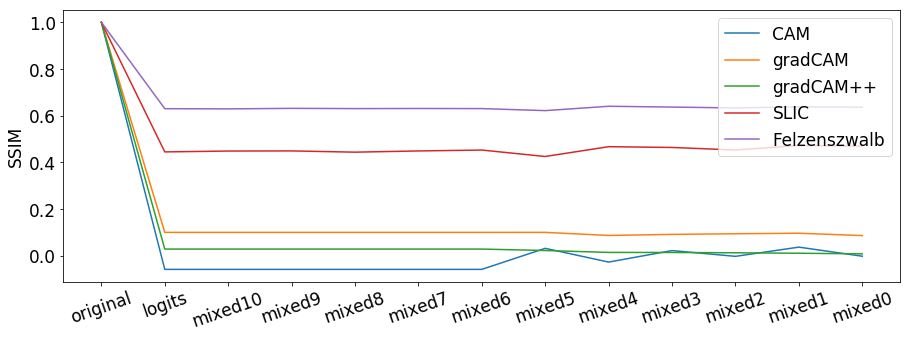

In [74]:
plt.rcParams['figure.figsize']=(15,5)
plt.rcParams['font.size']=17
plt.plot(ssim_list['CAM'])
plt.plot(ssim_list['gradCAM'])
plt.plot(ssim_list['gradCAM++'])
plt.plot(ssim_list['SLIC'])

plt.plot(ssim_list['Felzenszwalb'])
plt.legend(['CAM', 'gradCAM', 'gradCAM++', 'SLIC',  'Felzenszwalb'], loc='upper right')
plt.xticks(np.arange(len(ls)+1),['original', 'logits','mixed10',
 #'mixed9_1',
 #'mixed9_0',
 'mixed9',
 'mixed8',
'mixed7',
 'mixed6',
  'mixed5',
 'mixed4',
 'mixed3',
 'mixed2',
'mixed1',
 'mixed0'
], rotation=19)
plt.ylabel('SSIM')

In [72]:
plt.legend?

In [74]:
ssim_list2={'CAM':[], 'gradCAM':[], 'gradCAM++':[], 'SLIC':[], 'Felzenszwalb':[]}

for l in layers.keys():
    for meth in ['CAM', 'gradCAM', 'gradCAM++', 'SLIC',  'Felzenszwalb']:
        ssim_list2[meth].append(ssim(degradated_hm[0][meth], degradated_hm[l][meth]))

In [80]:
ssim(degradated_hm[0][meth], degradated_hm[l][meth])

0.742714106414312

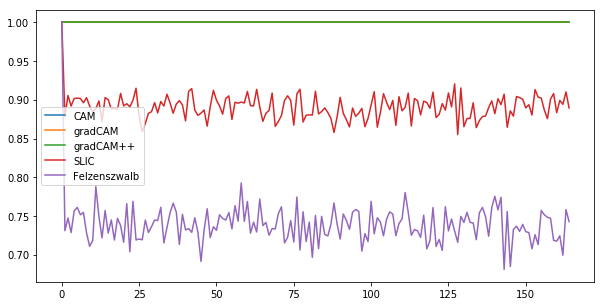

In [81]:
plt.rcParams['figure.figsize']=(10,5)
plt.plot(ssim_list2['CAM'])
plt.plot(ssim_list2['gradCAM'])
plt.plot(ssim_list2['gradCAM++'])
plt.plot(ssim_list2['SLIC'])

plt.plot(ssim_list2['Felzenszwalb'])
plt.legend(['CAM', 'gradCAM', 'gradCAM++', 'SLIC',  'Felzenszwalb'])

In [84]:
ssim_list2['gradCAM++']

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]